In [55]:
import sys
sys.path.append('../../../')
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence
from tifffile import imread
from tqdm import tqdm
import inspect
import glob
from sklearn.cluster import KMeans

In [56]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
patch_size = 64
centre_size = 4
n_channel = 32
hierarchy_level = 3

In [57]:
def load_model(dir):
    model = torch.load(dir+"Contrastive_MAE_best_vae.net")
    return model

In [58]:
def load_losses(dir):
    trainHist=np.load(dir+"train_loss.npy")
    reconHist=np.load(dir+"train_reco_loss.npy")
    klHist=np.load(dir+"train_kl_loss.npy")
    clHist=np.load(dir+"train_cl_loss.npy")
    valHist=np.load(dir+"val_loss.npy")
    return [trainHist, reconHist, klHist, clHist, valHist]

In [59]:
def plot_loss(losses):

    plt.figure(figsize=(18, 18))

    plt.subplot(2,2,1)
    plt.plot(losses['trainHist'],label='training')
    plt.plot(losses['valHist'],label='validation')
    plt.xlabel("epochs")
    plt.ylabel("overall loss")
    plt.legend()

    plt.subplot(2,2,2)
    plt.plot(losses['reconHist'],label='training')
    plt.xlabel("epochs")
    plt.ylabel("Inpainting loss")
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(losses['klHist'],label='training')
    plt.xlabel("epochs")
    plt.ylabel("KL loss")
    plt.legend()

    plt.subplot(2,2,4)
    plt.plot(losses['clHist'],label='training')
    plt.xlabel("epochs")
    plt.ylabel("CL loss")
    plt.legend()
    plt.show()

In [60]:
def get_normalized_tensor(img,model,device):
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images

In [61]:
def load_data(dir):
    return imread(dir)

In [62]:
model_dir = "/group/jug/Sheida/HVAE/Hyperparameter_search/copper-fire-507-cl1e-2_kl10/model/"
data_dir = "/localscratch/test_imgs/*"

In [63]:
model = load_model(model_dir)
loss_keys = ['trainHist', 'reconHist', 'klHist', 'clHist', 'valHist']
loss_dict = dict()
losses = load_losses(model_dir)
for index, key in enumerate(loss_keys):
    loss_dict[key] = losses[index]

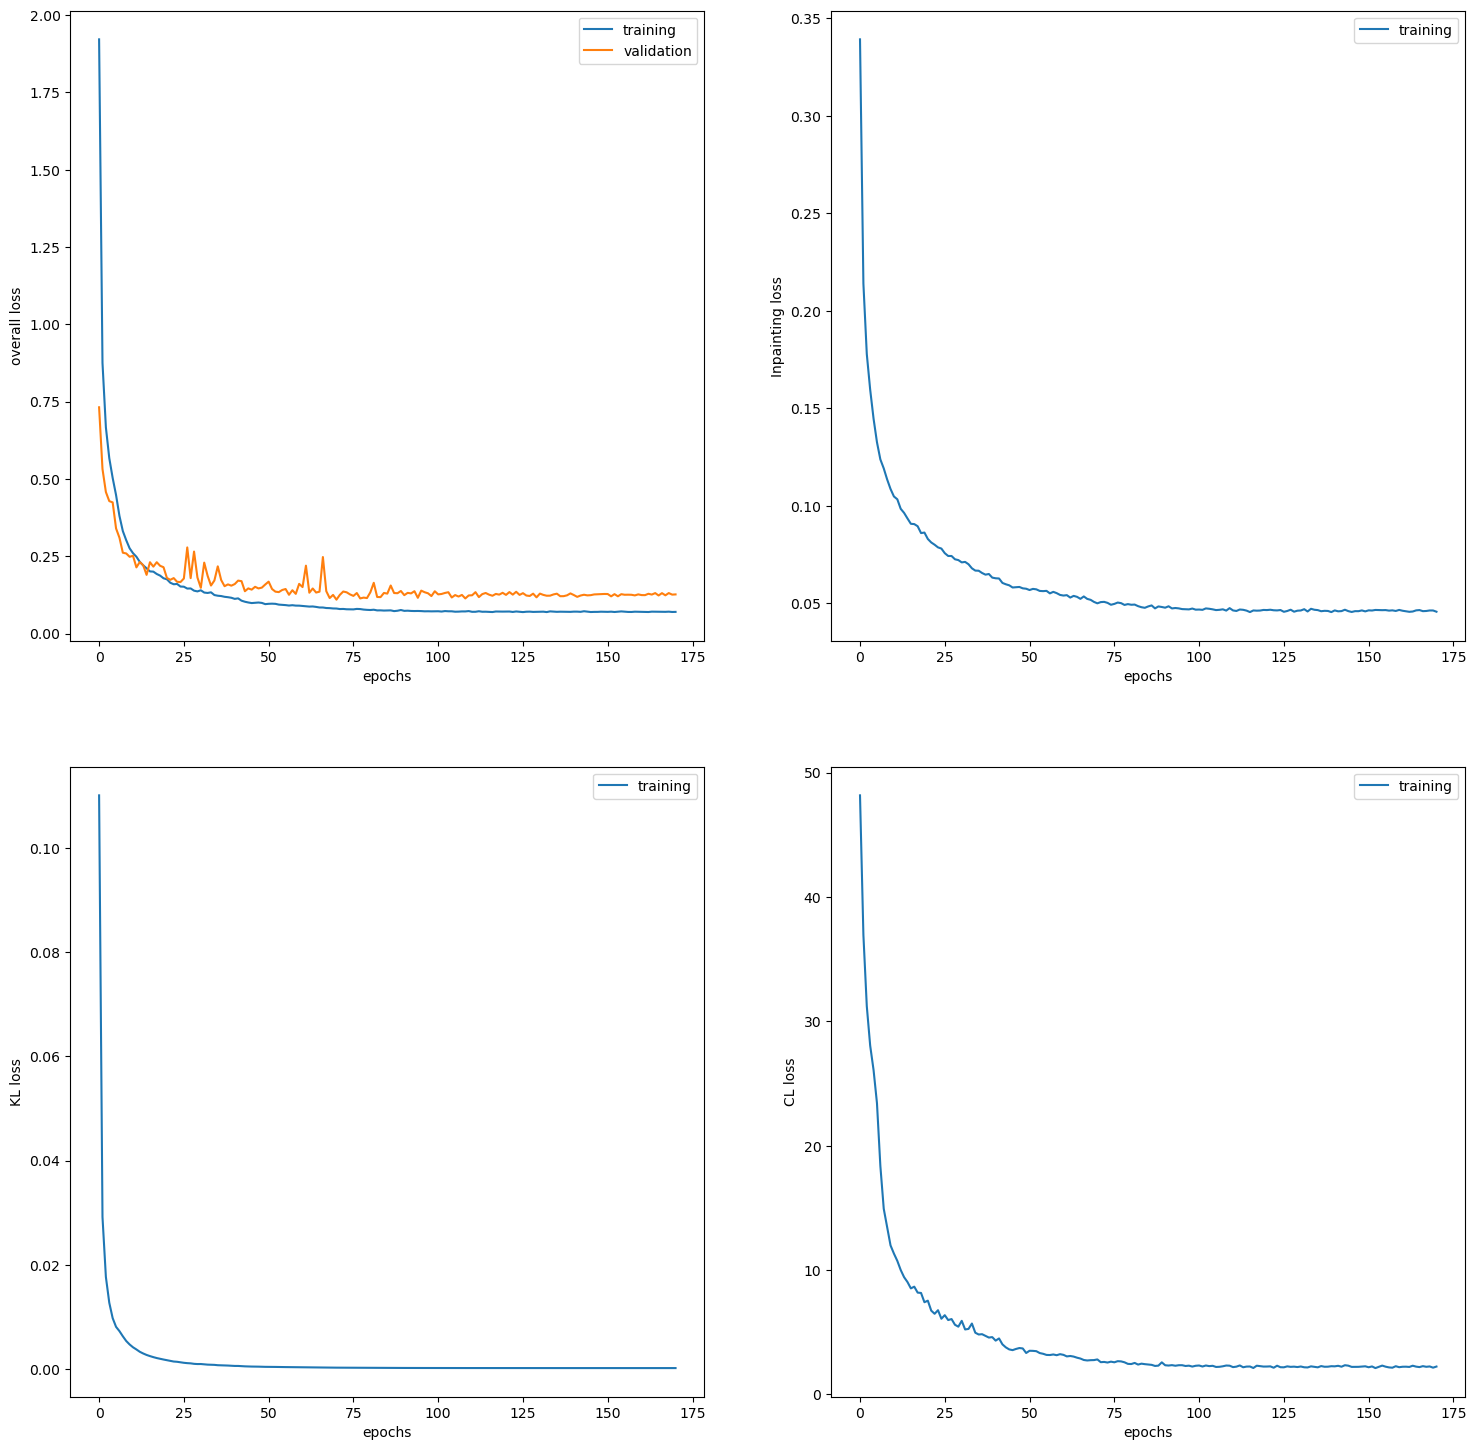

In [64]:
plot_loss(loss_dict)


In [65]:
imgs = load_data(sorted(glob.glob(data_dir)))

In [66]:
def mirror_image(image):
    """
    Mirror the borders of the image to handle edge cases.
    """
    pad_size = (patch_size - centre_size) // 2
    mirrored_image = np.pad(image, ((pad_size, pad_size)), mode='reflect')
    return mirrored_image

In [67]:
def extract_patch(image, x, y):
    """
    Extract a patch from the image centered at (x, y).
    """
    return image[y : y + patch_size, x : x + patch_size]

In [68]:
def get_mus(model, z):
    n_features = n_channel * hierarchy_level
    data = np.array([[]])
    model.mode_pred = True
    model.eval()
    with torch.no_grad():
        model.to(device)
        z = z.to(device=device, dtype=torch.float)
        z = z.reshape(1, 1, patch_size, patch_size)
        with torch.no_grad():
            sample = model(z, z, z, model_layers=[0, 1, 2])
            mu = sample["mu"]
            for i in range(hierarchy_level):
                np.append(data,mu[i].squeeze(0).cpu().numpy().reshape(-1, 32))
    return data

In [69]:
def predict_feature_maps(model, image):
    """
    Predict the feature maps for an image using the model.
    """
    height, width= image.shape
    pad_size = (patch_size-centre_size) // 2
    feature_map_size = 96
    # 189 width 174 height
    # Prepare a list to collect feature maps
    feature_maps = np.zeros((189, 174, 96))
    # Iterate over the image
    for y in range(0, height - patch_size, centre_size):
        for x in range(0, width - patch_size, centre_size):
            patch = extract_patch(image, x, y)
            mus = get_mus(model, patch)
            feature_maps[x//centre_size][y//centre_size] = mus
    # feature_maps = np.concatenate(feature_maps, axis=0)
    return feature_maps

In [70]:
x = get_normalized_tensor(mirror_image(imgs[0]),model,device)

In [71]:
def clustering(mu):
    slice_features_mu = mu.astype(float)
    feature_flatten_mu = slice_features_mu.reshape(-1, 96)
    K_CENTRE = 10
    kmeans_mu = KMeans(
        n_clusters=K_CENTRE, init='k-means++', n_init=10,
        max_iter=1000, random_state=777
    )
    kmeans_mu.fit(feature_flatten_mu)
    labels_mu = kmeans_mu.predict(feature_flatten_mu)
    return labels_mu

In [72]:
feature_maps = predict_feature_maps(model, x)

ValueError: could not broadcast input array from shape (0,) into shape (96,)

In [ ]:
feature_maps.shape

In [ ]:
plt.imshow(feature_maps[:,:,2])

In [ ]:
labels = clustering(feature_maps)

In [ ]:
labels.reshape(feature_maps.shape[0], feature_maps.shape[1]).shape

In [ ]:
plt.imshow(labels.reshape(feature_maps.shape[0], feature_maps.shape[1]))

In [ ]:
plt.imshow(imgs[0])

In [ ]:
np.unique(labels)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(labels.reshape(feature_maps.shape[0], feature_maps.shape[1]))
axes[0].set_title('Label')
axes[0].axis('off')

# Display the second image in the second subplot
axes[1].imshow(imgs[0])
axes[1].set_title('Image')
axes[1].axis('off')

# Show the plot
plt.show()